
<hr>
<font size=5 color='#3E54D3'> <b> Distracted Driver Detection - K. Weigel </b> </font>
<hr/>

Driver distraction is a specific type of driver inattention. Distraction occurs when drivers divert their attention from the driving task to focus on some other activity. Often discussions regarding distracted driving center around cell phone use and texting, but distracted driving also includes other activities such as eating, talking to other passengers, or adjusting the radio or climate controls.

In this project we will try to detect distracted dricers. The dataset can be found on [Kaggle](https://www.kaggle.com/competitions/state-farm-distracted-driver-detection/overview/description), and it consists of 22424 training images. The 10 classes to predict are:

* c0: safe driving
* c1: texting - right
* c2: talking on the phone - right
* c3: texting - left
* c4: talking on the phone - left
* c5: operating the radio
* c6: drinking
* c7: reaching behind
* c8: hair and makeup
* c9: talking to passenger

## 1 - Loading packages

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import math
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import torch.nn.functional as F
from torchsummary import summary
from torchvision import transforms, datasets, models
from torch.utils.data import Subset, random_split, DataLoader, Dataset
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
from PIL import Image

In [2]:
USE_GPU = True
dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


## 2 - Data preparation

In [3]:
def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(42)

In [ ]:
# zip_ref = zipfile.ZipFile('state-farm-distracted-driver-detection.zip', 'r')
# zip_ref.extractall('')
# zip_ref.close()

In [4]:
images_path = 'imgs/'

In [6]:
df = pd.read_csv('driver_imgs_list.csv')

In [7]:
df.head()

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [8]:
len(df)

22424

In [9]:
df.value_counts('classname')

classname
c0    2489
c3    2346
c4    2326
c6    2325
c2    2317
c5    2312
c1    2267
c9    2129
c7    2002
c8    1911
Name: count, dtype: int64

<Axes: xlabel='classname', ylabel='count'>

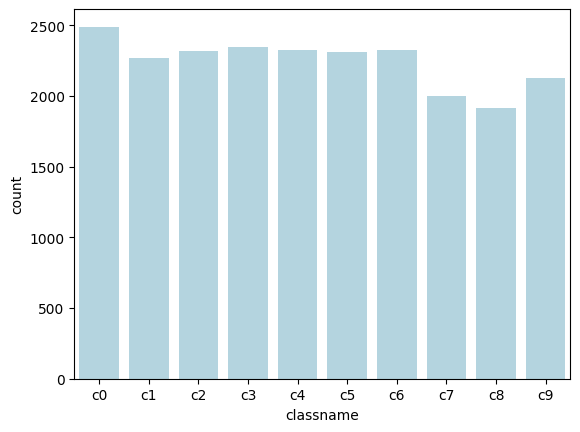

In [10]:
sns.countplot(df, x='classname', color='lightblue')

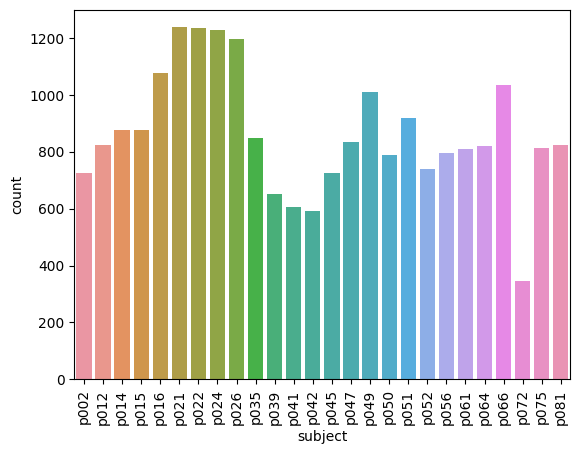

In [11]:
sns.countplot(df, x='subject')
plt.xticks(rotation=90)
plt.show()

<Axes: xlabel='subject', ylabel='count'>

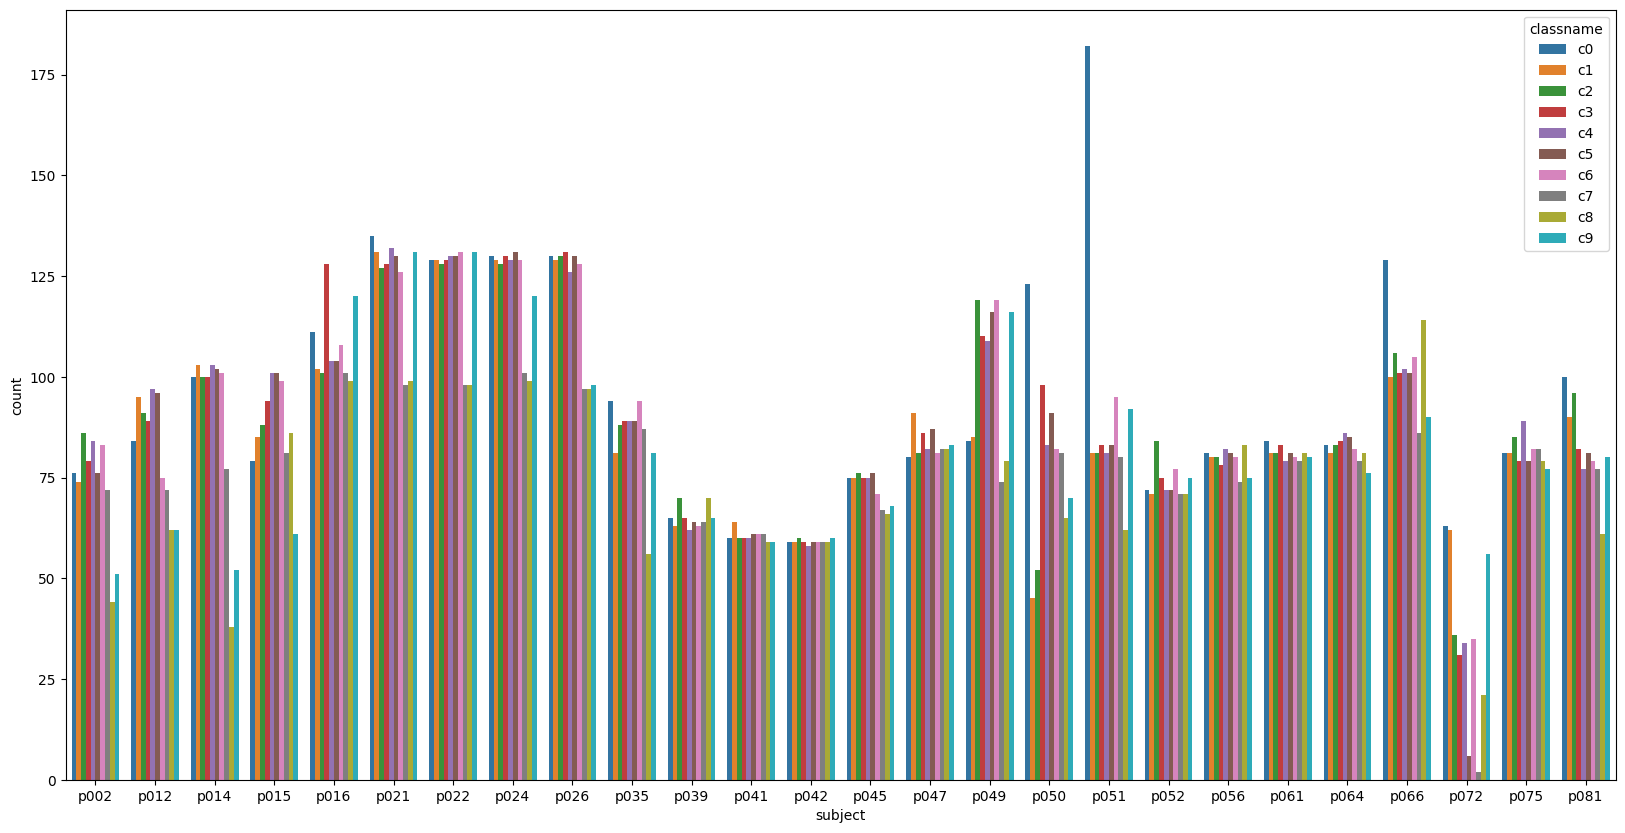

In [12]:
plt.figure(figsize=(20, 10))
sns.countplot(df, x='subject', hue='classname')

In [13]:
classes_dict = {'c0': 'safe driving',
                'c1': 'texting - right',
                'c2': 'talking on the phone - right',
                'c3': 'texting - left',
                'c4': 'talking on the phone - left',
                'c5': 'operating the radio',
                'c6': 'drinking',
                'c7': 'reaching behind',
                'c8': 'hair and makeup',
                'c9': 'talking to passenger'}

In [14]:
classes = sorted(df['classname'].unique().tolist())
classes

['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']

In [15]:
class2index = {cl: ind for ind, cl in enumerate(classes)}
class2index

{'c0': 0,
 'c1': 1,
 'c2': 2,
 'c3': 3,
 'c4': 4,
 'c5': 5,
 'c6': 6,
 'c7': 7,
 'c8': 8,
 'c9': 9}

In [16]:
training_df, val_df = train_test_split(df, train_size=0.8, stratify=df['classname'])
print(len(training_df))
print(len(val_df))

17939
4485


In [17]:
class DriverDataset(Dataset):
    def __init__(self, images_path, df, class2ind, transform=None):
        self.df = df
        self.images_path = images_path
        self.transform = transform
        self.class2index = class2ind

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        # get file from the dataframe
        filename = self.df.img[index]
        label = self.df.classname[index]
        image_path = os.path.join(self.images_path, label, filename)
        image = Image.open(image_path)
        label = self.class2index[label]
        if self.transform:
            image = self.transform(image)
        return image, label

In [18]:
IMG_SIZE = 64
transform_train = transforms.Compose([transforms.Resize((IMG_SIZE, IMG_SIZE)),
                                      transforms.RandomAutocontrast(),
                                      transforms.RandAugment(),
                                      transforms.RandomRotation(15),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                           std=[0.229, 0.224, 0.225])])

transform_val = transforms.Compose([transforms.Resize((IMG_SIZE, IMG_SIZE)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])

In [19]:
train_ds = DriverDataset(images_path + 'train', training_df.reset_index(), class2index, transform_train)
val_ds = DriverDataset(images_path + 'train', val_df.reset_index(), class2index, transform_val)

In [20]:
print('Number of training examples: ', len(train_ds))
print('Number of test examples: ', len(val_ds))

Number of training examples:  17939
Number of test examples:  4485


In [21]:
BATCH_SIZE = 32
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE)

In [22]:
def plot_data(generator):
    imgs, labels = next(generator)
    names = classes
    # re-normalize the images for plotting
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    imgs = imgs * std[None, :, None, None] + mean[None, :, None, None]

    fig = plt.figure(figsize=(10, 6))

    for i in range(16):
        plt.subplot(4, 4, i+1)
        image = imgs[i].numpy()
        image = np.transpose(image, (1, 2, 0))
        plt.imshow((image * 255).astype(np.uint8))
        plt.title(classes_dict[names[labels[i]]])
        plt.axis('off')

    fig.tight_layout()

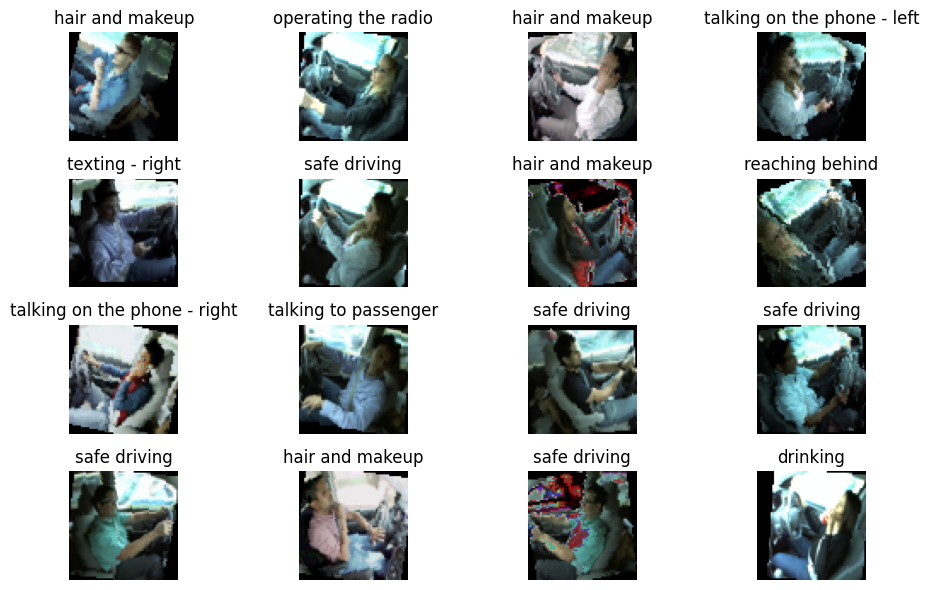

In [23]:
plot_data(iter(train_dl))

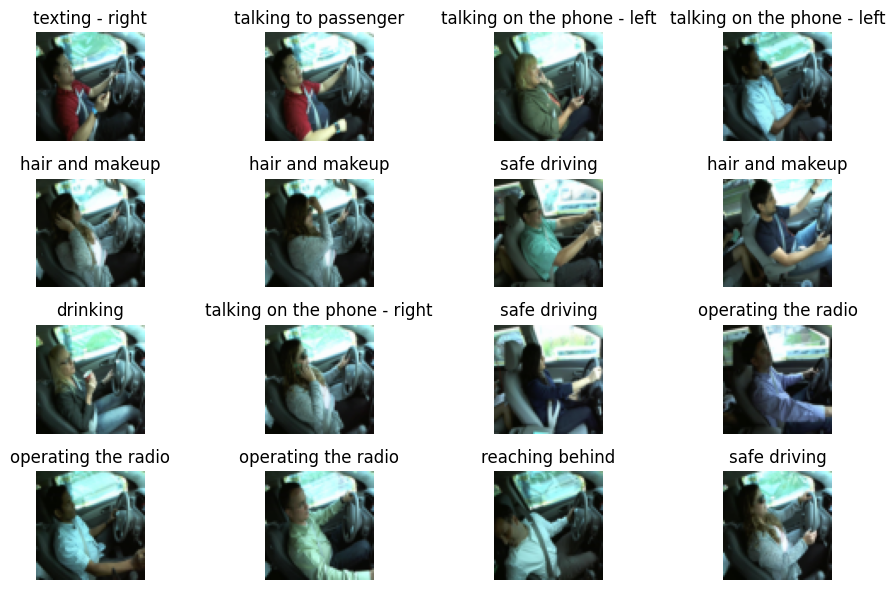

In [24]:
plot_data(iter(val_dl))

## 3 - Utility functions

In [25]:
# official pytorch function
def accuracy(output, target, topk=(1,)):
    """
    Computes the accuracy over the k top predictions 
    for the specified values of k
    """
    with torch.inference_mode():
        maxk = max(topk)
        batch_size = target.size(0)
        if target.ndim == 2:
            target = target.max(dim=1)[1]

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target[None])

        res = []
        for k in topk:
            correct_k = correct[:k].flatten().sum(dtype=torch.float32)
            #res.append(correct_k * (100.0 / batch_size))
            res.append(correct_k / batch_size)
        return res

    
def check_accuracy(model, loader):
    """
    Check accuracy of the model.

    Inputs:
    - model: A PyTorch model
    - loader: A DataLoader object to evaluate the model on

    Returns:
    - acc: Accuracy
    - loss: Loss
    """
    num_correct = 0
    num_samples = 0
    acc1, acc5 = 0, 0
    step_loss = []
    acc1_list = []
    acc5_list = []
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            loss = nn.functional.cross_entropy(scores, y)
            step_loss.append(loss.item())
            acc1_t, acc5_t = accuracy(scores, y, topk=(1, 5))
            acc1_list.append(acc1_t.detach().cpu().numpy())
            acc5_list.append(acc5_t.detach().cpu().numpy())
        acc1 = np.mean(acc1_list)
        acc5 = np.mean(acc5_list)

    return acc1, acc5, np.mean(step_loss)


def train_model(model, optimizer, epochs=1, show_every=10):
    """
    Train a model using the PyTorch Module API.

    Inputs:
    - model: A PyTorch Module giving the model to train
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    - show_every: Print result every show_every epoch

    Returns:
    - hist: Training history
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    hist = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'val_acc5': []}
    for e in range(epochs):
        step_loss = []
        num_correct = 0
        num_samples = 0
        for t, (x, y) in enumerate(train_dl):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            loss = nn.functional.cross_entropy(scores, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            step_loss.append(loss.item())
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)

        train_acc, train_loss = float(num_correct) / num_samples, np.mean(step_loss)
        # val_acc, val_loss = check_accuracy(model, val_dl)
        val_acc1, val_acc5, val_loss = check_accuracy(model, val_dl)
        hist['val_acc'].append(val_acc1)
        hist['val_acc5'].append(val_acc5)
        hist['val_loss'].append(val_loss)
        hist['train_acc'].append(train_acc)
        hist['train_loss'].append(train_loss)
        if (e + 1) % show_every == 0:
            print(f'Epoch {e+1}, train loss = {train_loss:.2f}, train acc = {train_acc:.2f},'
                  f' val loss = {val_loss:.2f}, val acc1 = {val_acc1:.2f}, val acc5 = {val_acc5:.2f}')

    return hist

In [26]:
def get_metrics(model, loader, n_classes):
    """
    Compute a confusion matrix.

    Inputs:
    - model: A PyTorch model
    - loader: A DataLoader object to evaluate the model on
    - n_classes: Number of classes in the classification task
    """
    model.eval()
    confusion_matrix = np.zeros((n_classes, n_classes))
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)

            for t, p in zip(y.cpu().numpy(), preds.cpu().numpy()):
                confusion_matrix[t, p] += 1

    return confusion_matrix

### Saliency map

A **saliency map** ([Deep Inside Convolutional Networks: Visualising
Image Classification Models and Saliency Maps, 2014](https://arxiv.org/abs/1312.6034)) tells us the degree to which each pixel in the image affects the classification score for that image. To compute it, we compute the gradient of the score corresponding to the correct class with respect to the input image. If the image has shape `(3, H, W)` then this gradient will also have shape `(3, H, W)`. For each pixel in the image, this gradient tells us the amount by which the classification score will change if the pixel changes by a small amount. To compute the saliency map, we take the absolute value of this gradient, then take the maximum value over the 3 input channels; the final saliency map thus has shape `(H, W)` and all entries are nonnegative.

In [52]:
def compute_saliency_maps(X, y, model):
    """
    Compute a class saliency map.

    Input:
    - X: Input images; Tensor of shape (N, 3, H, W)
    - y: Labels for X; Tensor of shape (N,)
    - model: A pretrained model that will be used to compute the saliency map.

    Returns:
    - saliency: A Tensor of shape (N, H, W) giving the saliency maps for the input
    images.
    """
    model.eval()

    if USE_GPU:
        X = X.cuda()
    input_X = Variable(X, requires_grad=True)
    
    if  input_X.grad is not None:
        input_X.grad.data.zero_()

    y = y.to(device=device, dtype=torch.long)
    # forward
    scores = model(input_X)
    loss = scores.gather(1, y.view(-1, 1)).squeeze().sum()

    # backward
    loss.backward()

    saliency, _ = input_X.grad.abs().max(axis=1)
    return saliency


def show_saliency_maps(X, y, model, num_imgs=6):
    # Compute saliency maps for images in X
    saliency = compute_saliency_maps(X, y, model)
    print(saliency.shape)
    
    if USE_GPU:
        saliency = saliency.cpu().numpy()
    else:
        saliency = saliency.numpy()
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    imgs = X * std[None, :, None, None] + mean[None, :, None, None]

    fig = plt.figure(figsize=(num_imgs*2, 3))
        
    for i in range(num_imgs):
        plt.subplot(2, num_imgs, i + 1)
        image = imgs[i].numpy()
        image = np.transpose(image, (1, 2, 0))
        plt.imshow((image * 255).astype(np.uint8))
        plt.axis('off')
        plt.title(classes[y[i]])
        plt.subplot(2, num_imgs, num_imgs + i + 1)
        plt.imshow(saliency[i], cmap=plt.cm.hot)
        plt.axis('off')
    fig.tight_layout()

## 4 - Vision Transformer

The Transformer architecture was initially proposed for sequence to sequence learning, with a focus on machine translation ([Vaswani et al., 2017](https://arxiv.org/abs/1706.03762)). Subsequently, Transformers emerged as the model of choice in various natural language processing tasks. Vision Transformer was proposed by [Dosovitskiy et al., 2021](https://arxiv.org/abs/2010.11929) as an analogous approach, but with application to computer vision tasks. It is an image classification model that views images as sequences of smaller patches. Each of those patches is considered to be a “word”/“token”, and projected to a feature space. With adding positional encodings and a token for classification on top, we can apply a Transformer as usual to this sequence and start training it for our task.


Below we discuss the parts of ViT in more detail.

* **Image Tokenization**: A standard transformer takes as
input a sequence of vectors, called tokens. To tokenize 2D images, we reshape the image $x \in \mathbb{R}^{H \times W \times C}$ into a
sequence of flattened 2D patches $x_p \in \mathbb{R}^{M \times (P^2 C)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $M = HW/P^2$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $d$ through all of its layers, so we flatten the patches and map to $d$ dimensions with a trainable linear projection. We refer to the output of this projection as the patch embeddings.
This is equivalent to a convolutional layer with $d$ filters, and $P \times P$ kernel and stride.
* **Positional Embedding**: Positional embeddings are added to retain spatial information, since the model does not know anything about the spatial relationship between tokens. Typically, this is either a learned 1D embedding or tokens are given weights from sine and cosine functions of different frequencies.
* **Transformer Encoder**: A transformer encoder consists
of a series of stacked encoding layers. Each such layer consists of multiheaded self-attention (MSA) and MLP blocks. Layernorm (LN) is applied before every block, and residual connections after every block.
* **Classification**: Vision transformers typically add an extra learnable `[class]` token to the sequence of the embedded patches.  `[class]` token gathers information from the other patches through self-attention.The output of this token is then transformed into a class prediction via a small multi-layer perceptron (MLP).


<img src="images/vit.png" style="width:750px;">
<caption><center> <u><b>Figure 1</u></b>: Vision Transformer <br> </center></caption>

### Attention
In 2014 [Bahdanau et al.](https://arxiv.org/pdf/1409.0473.pdf) proposed the attention mechanism with application to machine translation to deal with the problem that the early encoder-decoder architecture faced, namely that of fixed-length vector from which a decoder generates a translation. In 2017, the attention mechanism was used in Transformer networks by [Vaswani et al.](https://arxiv.org/abs/1706.03762).

> An attention function can be described as mapping a query and a set of key-value pairs to an output, where the query, keys, values, and output are all vectors. The output is computed as a weighted sum of the values, where the weight assigned to each value is computed by a compatibility function of the query with the corresponding key. (Vaswani et al., 2017)

The attention mechanism mimics the retrieval of a value $v_i$ for a query $q$, based on a key $k_i$ in a database. To formalize the idea let us introduce a set (database) $\mathcal{D}$ of key-value pairs, $\mathcal{D} = \{(k_1, v_1), \dots, (k_T, v_T)\}$

$$
\text{Attention}(q, \mathcal{D}) = \sum_{i} \alpha (q, k_i) v_i,
$$

where $\alpha (q, k_i) \in \mathbb{R}$ are scalar attention weights. The operation itself is typically referred to as *attention pooling*. The name attention derives from the fact that the operation pays particular attention to the terms for which the weight $\alpha$ is significant (i.e., large).

We can put different constraints on the weights, some common strategies include:

* The weights $\alpha(q, k_i)$ are nonnegative. In this case the output of the attention mechanism is contained in the convex cone spanned by the values $v_i$

* The weights form a convex combination, i.e., $\sum_i \alpha(q, k_i) = 1$ and $\alpha(q, k_i) \geq 0$ for all $i$. This is the most common setting in deep learning.

* Exactly one of the weights is equal to 1, while all the others are set to 0. This imitates the behavior of a traditional database query.

* All weights are equal.

As has been pointed out, the most common strategy in deep learning is for the weights to form a convex combination of values $v_i$. This condition can easily be enforced by wrapping any real valued function in the softmax operation:

$$
\alpha(q, k_i) = \frac{\exp(a(q, k_i))}{\sum_j \exp(a(q, k_j))}.
$$

In Transformer networks we most commonly use *scaled dot product attention*

$$
a(q, k_i) = \frac{q^Tk_i}{\sqrt{d}},
$$

where $d$ is the dimensionality of $q$ and $k$ (the embedding dimension).





#### Self-Attention
In Transformers, we perform self-attention, which means that the values, keys and queries are derived from the input $X \in \mathbb{R}^{T \times d}$, where $T$ is our sequence length. Specifically, we learn parameter matrices $W_V, W_K, W_Q \in \mathbb{R}^{d\times d}$ to map our input $X$ as follows:

$$
\begin{aligned}
v_i &= W_Vx_i\ \ i \in \{1,\dots,T\}\\
k_i &= W_Kx_i\ \ i \in \{1,\dots,T\}\\
q_i &= W_Qx_i\ \ i \in \{1,\dots,T\}
\end{aligned}
$$

<img src="images/attention_graph.png" style="width:750px;">
<caption><center> <u><b>Figure 2</u></b>: Self-Attention mechanism <br> </center></caption>


We can stack the queries, keys and values into $T \times d$ matrices, where $T$ is the sequence length (number of tokens), and $d$ is the embedding dimension. That way we can perform self-attention simultaneously via matrix multiplication. This type of self-attention can be mathematically expressed as:

$$
\text { Attention }(Q, K, V)=\operatorname{softmax}\left(\frac{Q K^{T}}{\sqrt{d}}\right) V
$$

* $Q$ is the matrix of queries, $Q = XW_Q, Q \in \mathbb{R}^{T \times d}$
* $K$ is the matrix of keys, $K = XW_K, K \in \mathbb{R}^{T \times d}$
* $V$ is the matrix of values, $V = XW_V, V \in \mathbb{R}^{T \times d}$
* $d$ is the embedding dimension


#### Multi-Headed Self-Attention

<img src="images/multiheadattention.png" style="width:550px;">
<caption><center> <u><b>Figure 3</u></b>: Multi-Headed Self-Attention <br> </center></caption>

In the case of multi-headed attention, we learn a parameter matrix for each head, which gives the model more expressivity to attend to different parts of the input. Let $h$ be number of heads, and $Y_i$ be the attention output of head $i$. Thus we learn individual matrices $W_{Q_i}$, $W_{K_i}$ and $W_{V_i}$. To keep our overall computation the same as the single-headed case, we choose $W_{Q_i} \in \mathbb{R}^{d\times d/h}$, $W_{K_i} \in \mathbb{R}^{d\times d/h}$ and $W_{V_i} \in \mathbb{R}^{d\times d/h}$. We have:

$$
Y_i = \text{softmax}\bigg(\frac{Q_iK_i^T}{\sqrt{d/h}}\bigg)V_i
$$

where $Y_i\in\mathbb{R}^{T \times d/h}$, where $T$ is our sequence length.

In our implementation, we apply dropout to the attention weights:

$$
Y_i = \text{dropout}\bigg(\text{softmax}\bigg(\frac{Q_iK_i^T}{\sqrt{d/h}}\bigg)\bigg)V_i
$$

Finally, then the output of the self-attention is a linear transformation of the concatenation of the heads:

$$
Y = [Y_1;\dots;Y_h]A
$$

were $A \in\mathbb{R}^{d\times d}$ and $[Y_1;\dots;Y_h]\in\mathbb{R}^{T \times d}$.



In [28]:
def img_to_patch(x, patch_size, flatten_imgs=True):
    """
    Split an image to patches.

    Inputs:
    - x: Tensor representing a batch of N images, shape (N, C, H, W)
    - patch_size: Patch spatial dimension
    - flatten_imgs: If True returns flattened patches Tensor of size 
      (N, no. of patches, patch size unrolled), otherwise returns non-flattened
      Tensor of patches of size (N, no. of patches, C, patch_size, patch_size)
    """

    N, C, H, W = x.shape
    new_H = new_W = H // patch_size
    # (N, C, H', P, W', P)
    x = x.reshape(N, C, new_H, patch_size, new_W, patch_size)
    # (N, C, H', P, W', P) -> (N, H', W', C, P, P)
    x = x.permute(0, 2, 4, 1, 3, 5)

    if flatten_imgs == True:
        # (N, number of patches, patch size unrolled)
        x = x.reshape(N, new_H * new_W, patch_size * patch_size * C)
    else:
        # (N, number of patches, C, P, P)
        x = x.reshape(N, new_H * new_W, C, patch_size, patch_size)

    return x

In [29]:
batch = next(iter(train_dl))
patch = img_to_patch(batch[0], IMG_SIZE//4, flatten_imgs=False)

In [30]:
patch.shape

torch.Size([32, 16, 3, 16, 16])

In [31]:
batch[0].shape

torch.Size([32, 3, 64, 64])

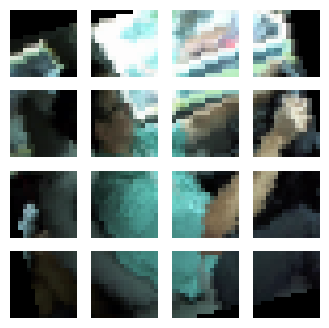

In [32]:
# print the first image in patches
imgs = patch[0]
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
imgs = imgs * std[None, :, None, None] + mean[None, :, None, None]

fig = plt.figure(figsize=(4, 4))

for i in range(16):
    plt.subplot(4, 4, i+1)
    image = imgs[i].numpy()
    image = np.transpose(image, (1, 2, 0))
    plt.imshow((image * 255).astype(np.uint8))
    plt.axis('off')

In [33]:
class MultiHeadAttention(nn.Module):
    """
    A model layer which implements a simplified version of masked attention, as
    introduced by "Attention Is All You Need" (https://arxiv.org/abs/1706.03762).

    Usage:
      attn = MultiHeadAttention(embed_dim, num_heads=2)

      # self-attention
      data = torch.randn(batch_size, sequence_length, embed_dim)
      self_attn_output = attn(query=data, key=data, value=data)

      # attention using two inputs
      other_data = torch.randn(batch_size, sequence_length, embed_dim)
      attn_output = attn(query=data, key=other_data, value=other_data)
    """

    def __init__(self, embed_dim, num_heads, dropout=0.1):
        """
        Inputs:
         - embed_dim: Embedding dimension
         - num_heads: Number of attention heads
         - dropout: Dropout probability
        """
        super().__init__()
        assert embed_dim % num_heads == 0

        self.key = nn.Linear(embed_dim, embed_dim)
        self.query = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.proj = nn.Linear(embed_dim, embed_dim)

        self.attn_drop = nn.Dropout(dropout)

        self.n_head = num_heads
        self.emd_dim = embed_dim
        self.head_dim = self.emd_dim // self.n_head

    def forward(self, query, key, value, attn_mask=None):
        """
        S - source sequence length, 
        T - target sequence length (T=S for self-attention),
        E - embedding dimension.

        Inputs:
        - query: Input data to be used as the query, of shape (N, S, E)
        - key: Input data to be used as the key, of shape (N, T, E)
        - value: Input data to be used as the value, of shape (N, T, E)
        - attn_mask: Array of shape (S, T) where mask[i,j] == 0 indicates token
          i in the source should not influence token j in the target.

        Returns:
        - output: Tensor of shape (N, S, E) giving the weighted combination of
          data in value according to the attention weights calculated using key
          and query.
        """
        N, S, E = query.shape
        N, T, E = value.shape
        output = torch.empty((N, S, E))

        # get number of heads
        H = self.n_head
        # split the key, value, query matrices so that each head is separated
        K = self.key(key).view(N, T, H, E//H)
        Q = self.query(query).view(N, S, H, E//H)
        V = self.value(value).view(N, T, H, E//H)

        # batched matrix multiply
        # (N, H, S, E/H) * (N, H, E/H, T) -> (N, H, S, T)
        Y = torch.matmul(Q.moveaxis(1, 2), K.moveaxis(1, 2).transpose(2, 3))
        Y = Y / math.sqrt(E / H)
        if attn_mask is not None:
            Y = Y.masked_fill(attn_mask==0, float('-inf'))

        Y = self.attn_drop(F.softmax(Y, dim=-1))
        # (N, H, S, T) * (N, H, T, E/H) -> (N, H, S, E/H)
        Y = torch.matmul(Y, V.moveaxis(1, 2))
        output = self.proj(Y.moveaxis(1, 2).reshape(N, S, E))

        return output

In [34]:
class ViTLayer(nn.Module):
    """
    A single ViT layer, consisting of MSA, layer norm, MLP with residual 
    connections.
    """
    def __init__(self, num_heads, embed_dim, hidden_dim, dropout=0.1):
        """
        Inputs:
        - num_heads: Number of heads for multi-headed self-attention
        - embed_dim: Dimension of key, query, and value embeddings
        - hidden_dim: Hidden dimension of the linear layer
        - dropout: Dropout probability for the MLP block
        """
        super().__init__()

        self.msa = MultiHeadAttention(embed_dim, num_heads)

        self.layernorm1 = nn.LayerNorm(embed_dim)
        self.layernorm2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        inp_x = self.layernorm1(x)
        x = x + self.msa(inp_x, inp_x, inp_x)
        x = x + self.mlp(self.layernorm2(x))

        return x

In [35]:
class ViT(nn.Module):
    """
    Vision Transformer
    """
    def __init__(
        self,
        patch_size,
        input_size,
        embed_dim,
        hidden_dim,
        num_classes,
        num_layers,
        num_heads,
        dropout=0.1,
        num_channels=3):
        """
        Inputs:
        - patch_size: Spatial dimesion of patches
        - input_size: Input size of the image
        - embed_dim: Size of the embedding
        - hidden_dim: Size of the MLP hidden dimension
        - num_classes: Number of classes
        - num_layers: Number of ViT layers
        - num_heads: Number of MSA heads
        - dropout: Dropout probability
        - num_channels: Number of channels in the input image
        """
        super().__init__()

        self.patch_size = patch_size
        # Patch embedding
        self.input_layer = nn.Linear(num_channels * (patch_size**2), embed_dim)
        # Classification token
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        # Positional embedding as a learnable parameter
        self.position_embedding = nn.Parameter(
            torch.randn(1, (input_size // patch_size) ** 2 + 1, embed_dim)
        )
        # Transformer network
        self.transformer = nn.Sequential(
            *(ViTLayer(num_heads, embed_dim, hidden_dim, dropout=dropout) for _ in range(num_layers))
        )
        # Classifier
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, num_classes)
        )
        # Embedding dropout
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = img_to_patch(x, self.patch_size)
        x = self.input_layer(x)
        N, S, E = x.shape

        # batch of cls tokens stacked stacked on rows -> (N, 1, embed_dim)
        cls_token_batch = torch.tile(self.cls_token, (N, 1, 1))
        # add cls token as an additional patch
        x = torch.cat([cls_token_batch, x], dim=1)
        # add positional embedding
        x = x + self.position_embedding

        # apply embedding dropout
        x = self.dropout(x)
        # pass through transformer network
        x = self.transformer(x)

        # pass the classifiation token through the classifier network
        out = self.mlp_head(x[:, 0])

        return out

In [36]:
def init_weight(m):
    if isinstance(m, nn.Linear):
        nn.init.trunc_normal_(m.weight, std=.02)
        if isinstance(m, nn.Linear) and m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.LayerNorm):
        nn.init.constant_(m.bias, 0)
        nn.init.constant_(m.weight, 1.0)

In [37]:
vit_model = ViT(patch_size=4,
        input_size=IMG_SIZE,
        embed_dim=64,
        hidden_dim=128,
        num_classes=10,
        num_layers=6,
        num_heads=8)

In [38]:
summary(vit_model.cuda(), (3, IMG_SIZE, IMG_SIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 256, 64]           3,136
           Dropout-2              [-1, 257, 64]               0
         LayerNorm-3              [-1, 257, 64]             128
            Linear-4              [-1, 257, 64]           4,160
            Linear-5              [-1, 257, 64]           4,160
            Linear-6              [-1, 257, 64]           4,160
           Dropout-7          [-1, 8, 257, 257]               0
            Linear-8              [-1, 257, 64]           4,160
MultiHeadAttention-9              [-1, 257, 64]               0
        LayerNorm-10              [-1, 257, 64]             128
           Linear-11             [-1, 257, 128]           8,320
             GELU-12             [-1, 257, 128]               0
          Dropout-13             [-1, 257, 128]               0
           Linear-14              [-1, 

In [39]:
#vit_model.apply(init_weight)
optimizer = optim.Adam(vit_model.parameters(), lr=3e-4)
hist_vit = train_model(vit_model, optimizer, epochs=100, show_every=5)

Epoch 5, train loss = 2.21, train acc = 0.17, val loss = 1.98, val acc1 = 0.29, val acc5 = 0.79
Epoch 10, train loss = 1.71, train acc = 0.38, val loss = 1.17, val acc1 = 0.59, val acc5 = 0.96
Epoch 15, train loss = 1.45, train acc = 0.48, val loss = 0.80, val acc1 = 0.75, val acc5 = 0.98
Epoch 20, train loss = 1.25, train acc = 0.56, val loss = 0.59, val acc1 = 0.82, val acc5 = 0.99
Epoch 25, train loss = 1.08, train acc = 0.62, val loss = 0.45, val acc1 = 0.85, val acc5 = 0.99
Epoch 30, train loss = 0.95, train acc = 0.67, val loss = 0.36, val acc1 = 0.89, val acc5 = 0.99
Epoch 35, train loss = 0.84, train acc = 0.70, val loss = 0.28, val acc1 = 0.91, val acc5 = 1.00
Epoch 40, train loss = 0.74, train acc = 0.75, val loss = 0.23, val acc1 = 0.92, val acc5 = 1.00
Epoch 45, train loss = 0.63, train acc = 0.78, val loss = 0.19, val acc1 = 0.94, val acc5 = 1.00
Epoch 50, train loss = 0.57, train acc = 0.80, val loss = 0.17, val acc1 = 0.95, val acc5 = 1.00
Epoch 55, train loss = 0.51, tr

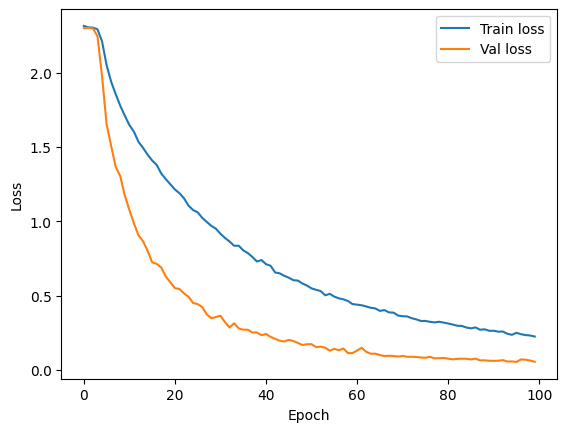

In [40]:
plt.plot(hist_vit['train_loss'], label='Train loss')
plt.plot(hist_vit['val_loss'], label='Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

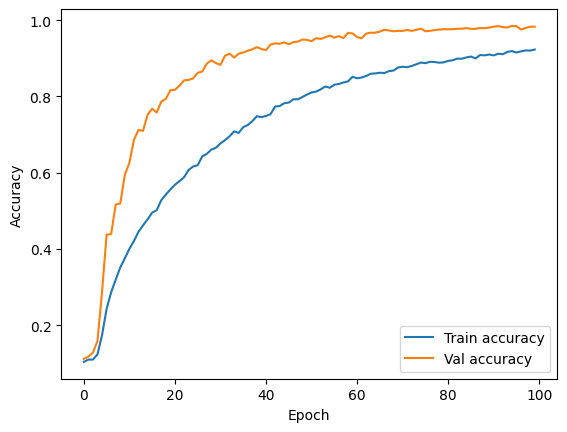

In [41]:
plt.plot(hist_vit['train_acc'], label='Train accuracy')
plt.plot(hist_vit['val_acc'], label='Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [42]:
cm = get_metrics(vit_model, val_dl, 10)

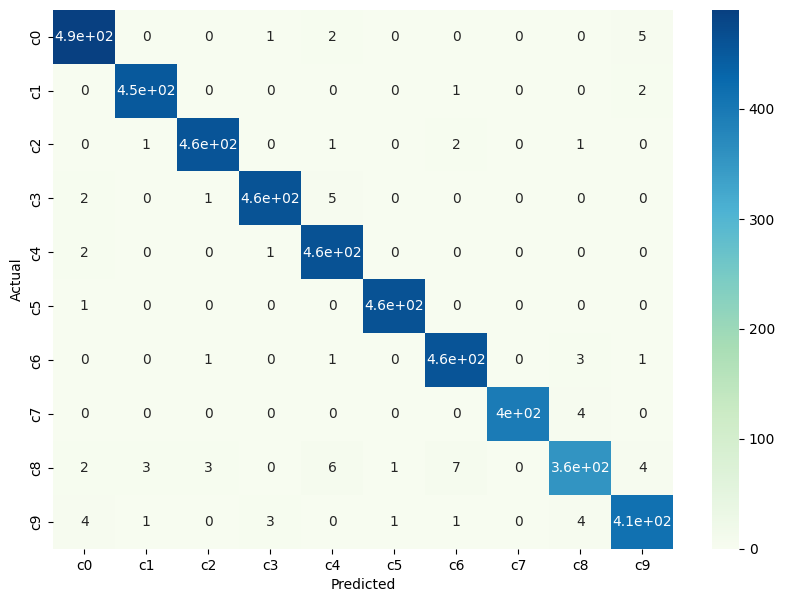

In [43]:
df_cm = pd.DataFrame(cm, index = [cl for cl in classes],
                     columns = [cl for cl in classes])
plt.figure(figsize = (10, 7))
sns.heatmap(df_cm, annot=True, cmap='GnBu')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [44]:
X, y = next(iter(val_dl))

torch.Size([32, 64, 64])


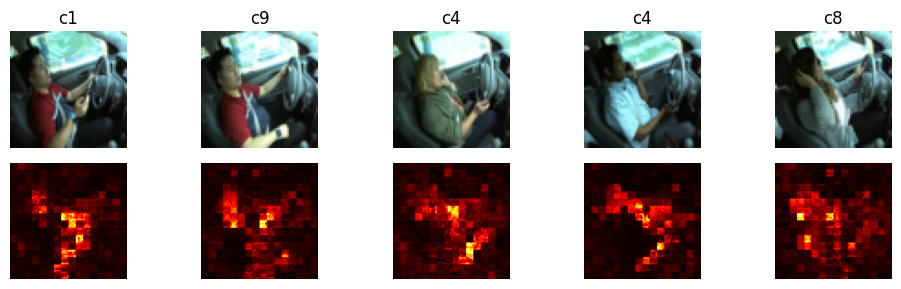

In [53]:
show_saliency_maps(X, y, vit_model, 5)

In [50]:
torch.save(vit_model.state_dict(), 'vit_model.pth')

In [ ]:
# vit_model = ViT(patch_size=4,
#         input_size=64,
#         embed_dim=64,
#         hidden_dim=128,
#         num_classes=10,
#         num_layers=6,
#         num_heads=8)
# vit_model.load_state_dict(torch.load('vit_model.pth'))

## 5 - Compact Convolutional Vision Transformer

Here we will implement Compact Convolutional Transformer, a model proposed by [Hassani et al., 2021](https://arxiv.org/abs/2104.05704), which introduces some design changes to the original Transformer architecture.

* **Sequence Pooling** method (SeqPool), that pools the entire sequence of tokens produced by the transformer encoder. SeqPool replaces the conventional `[class]` token. The motivation of this technique is that the output sequence contains relevant information across different parts of the input image, therefore preserving this information can improve performance, and at no additional parameters compared to the learnable token. Additionally, this change slightly decreases computation, due one less token being forwarded. This operation consists of mapping the output sequence using the transformation $F: \mathbb{R}^{N \times T \times d} \mapsto \mathbb{R}^{N \times d}$, where $N$ is the batch size, $T$ is the sequence length and $d$ is the embedding dimension. Let $x_L$ be the output of an $L$ layer transformer encoder $f$:
$$
x_{L} = f(x_0) \in \mathbb{R}^{N \times T \times d}.
$$
In a SeqPool block $x_L$ is fed to a linear layer $g(x_L) \in \mathbb{R}^{d \times 1}$, and a softmax activation function is applied to the output:
$$
x_L' = \text{softmax}(g(x_L)^T) \in \mathbb{R}^{N \times 1 \times d}.
$$
This generates weights, that are then applied to the input:
$$
z = x_L'x_L = \text{softmax}(g(x_L)^T) x_L \in \mathbb{R}^{N \times 1 \times d}.
$$
By flattening the output, we get $z \in \mathbb{R}^{N \times d}$.
* **Convolutional Tokenizer**, which generates richer tokens and preserves local information. It follows standard CNN design with a convolutional layer, followed by the ReLU activation and a pooling layer.
$$
x_0 = \text{MaxPool}(\text{ReLU}(\text{Conv2d}(x))),
$$
where $x \in \mathbb{R}^{H \times W \times C}$ is the input image.

In [51]:
class SeqPool(nn.Module):
    """
    Sequence Pooling method (SeqPool), that pools the entire sequence
    of tokens produced by the transformer encoder.
    """
    def __init__(self, embed_dim):
        """
        Inputs:
        - embed_dim: Embedding dimension
        """
        super().__init__()
        self.linear = nn.Linear(embed_dim, 1)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        """
        Inputs:
        - x: output of the transformer network (N, S, E)
        """
        N, S, E = x.shape
        # (N, S, 1)
        z = self.linear(x)
        # (N, 1, S)
        z = z.transpose(1, 2)
        z = self.softmax(z)
        # batched matrix multiply
        # (N, 1, S) * (N, S, E) -> (N, 1, E)
        z = torch.matmul(z, x)
        z = z.reshape(N, E)

        return z

In [54]:
class ConvTokenizer(nn.Module):
    """
    Convolutional tokenizer
    """
    def __init__(
        self,
        num_channels=3,
        embed_dim=256,
        conv_kernel=3,
        conv_stride=2,
        conv_padding=1,
        pool_kernel=2,
        pool_stride=2):
        """
        Inputs:
        - num_channels: Number of channels in the input image
        - embed_dim: Embedding dimension
        - conv_kernel: Filter size in the convolutional layer
        - conv_stride: Stride value in the conv layer
        - conv_padding: Padding size in the conv layer
        - pool_kernel: Filter size in the pooling layer
        - pool_stride: Stride value in the pooling layer
        """
        super().__init__()
        self.tokenizer = nn.Sequential(
            nn.Conv2d(in_channels=num_channels, out_channels=embed_dim,
                      kernel_size=conv_kernel, stride=conv_stride, padding=conv_padding),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=pool_kernel, stride=pool_stride),
        )
        self.flatten = nn.Flatten(2, 3)

    def sequence_length(self, n_channels=3, height=224, width=224):
        """
        Return sequence length.
        """
        return self.forward(torch.zeros((1, n_channels, height, width))).shape[1]

    def forward(self, x):
        """
        Inputs:
        - x: Input tensor of images, shape (N, C, H, W)

        Outputs:
        - tokens: Tensor representing tokens of shape (N, S, E)
        """
        tokens = self.flatten(self.tokenizer(x)).transpose(1, 2)

        return tokens

In [55]:
x = torch.randn(16, 3, 64, 64)
t = ConvTokenizer(conv_kernel=3, conv_stride=2, conv_padding=1)
t(x).shape

torch.Size([16, 256, 256])

In [56]:
class CCT(nn.Module):
    """
    Compact Convolutional Transformer
    """
    def __init__(
        self,
        input_size,
        embed_dim,
        hidden_dim,
        num_classes,
        num_layers,
        num_heads,
        conv_kernel=3,
        conv_stride=1,
        conv_padding=1,
        pool_kernel=2,
        pool_stride=2,
        dropout=0.1,
        num_channels=3):
        """
        Inputs:
        - input_size: Input size of the image
        - embed_dim: Embedding dimension
        - hidden_dim: Dimension of the linear layer
        - num_classes: Number of classes
        - num_heads: Number of MSA heads
        - conv_kernel: Filter size in the convolutional layer
        - conv_stride: Stride value in the conv layer
        - conv_padding: Padding size in the conv layer
        - pool_kernel: Filter size in the pooling layer
        - pool_stride: Stride value in the pooling layer
        - dropout: Dropout probability
        - num_channels: Number of channels in the input image
        """

        super().__init__()
        self.tokenizer = ConvTokenizer(
            num_channels,
            embed_dim,
            conv_kernel=conv_kernel,
            conv_stride=conv_stride,
            conv_padding=conv_padding)
        seq_len = self.tokenizer.sequence_length(num_channels, input_size, input_size)
        # Positional embedding as a learnable parameter
        self.position_embedding = nn.Parameter(torch.randn(1, seq_len, embed_dim))
        # Transformer network
        self.transformer = nn.Sequential(
            *(ViTLayer(num_heads, embed_dim, hidden_dim, dropout=dropout) for _ in range(num_layers))
        )
        # Sequence pooling
        self.seq_pool = SeqPool(embed_dim)
        # Classifier
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, num_classes)
        )
        # Embedding dropout
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.tokenizer(x)
        # x = self.input_layer(x)
        N, S, E = x.shape

        # add positional embedding
        x = x + self.position_embedding

        # apply embedding dropout
        x = self.dropout(x)
        # pass through transformer network
        x = self.transformer(x)
        # sequence pooling
        x = self.seq_pool(x)

        # pass the sequence pooling output through the classifier network
        out = self.mlp_head(x)

        return out

In [57]:
cct_model = CCT(
    input_size=IMG_SIZE,
    embed_dim=64,
    hidden_dim=128,
    num_classes=10,
    num_layers=6,
    num_heads=8,
    conv_kernel=3,
    conv_stride=2,
    conv_padding=1,
    dropout=0.1
)

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

In [58]:
summary(cct_model.cuda(), (3, IMG_SIZE, IMG_SIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
         MaxPool2d-3           [-1, 64, 16, 16]               0
           Flatten-4              [-1, 64, 256]               0
     ConvTokenizer-5              [-1, 256, 64]               0
           Dropout-6              [-1, 256, 64]               0
         LayerNorm-7              [-1, 256, 64]             128
            Linear-8              [-1, 256, 64]           4,160
            Linear-9              [-1, 256, 64]           4,160
           Linear-10              [-1, 256, 64]           4,160
          Dropout-11          [-1, 8, 256, 256]               0
           Linear-12              [-1, 256, 64]           4,160
MultiHeadAttention-13              [-1, 256, 64]               0
        LayerNorm-14              [-1,

In [59]:
# optimizer = optim.Adam(cct_model.parameters(), lr=4e-5)
# cct_model.apply(init_weight)
optimizer = optim.Adam(cct_model.parameters(), lr=3e-4)
hist_cct = train_model(cct_model, optimizer, epochs=100, show_every=5)

Epoch 5, train loss = 2.06, train acc = 0.24, val loss = 1.68, val acc1 = 0.41, val acc5 = 0.90
Epoch 10, train loss = 1.64, train acc = 0.41, val loss = 1.08, val acc1 = 0.62, val acc5 = 0.97
Epoch 15, train loss = 1.38, train acc = 0.51, val loss = 0.71, val acc1 = 0.77, val acc5 = 0.99
Epoch 20, train loss = 1.18, train acc = 0.58, val loss = 0.55, val acc1 = 0.81, val acc5 = 0.99
Epoch 25, train loss = 1.01, train acc = 0.65, val loss = 0.41, val acc1 = 0.87, val acc5 = 0.99
Epoch 30, train loss = 0.86, train acc = 0.70, val loss = 0.29, val acc1 = 0.91, val acc5 = 1.00
Epoch 35, train loss = 0.76, train acc = 0.73, val loss = 0.22, val acc1 = 0.94, val acc5 = 1.00
Epoch 40, train loss = 0.67, train acc = 0.77, val loss = 0.20, val acc1 = 0.94, val acc5 = 1.00
Epoch 45, train loss = 0.58, train acc = 0.80, val loss = 0.15, val acc1 = 0.95, val acc5 = 1.00
Epoch 50, train loss = 0.52, train acc = 0.82, val loss = 0.14, val acc1 = 0.96, val acc5 = 1.00
Epoch 55, train loss = 0.46, tr

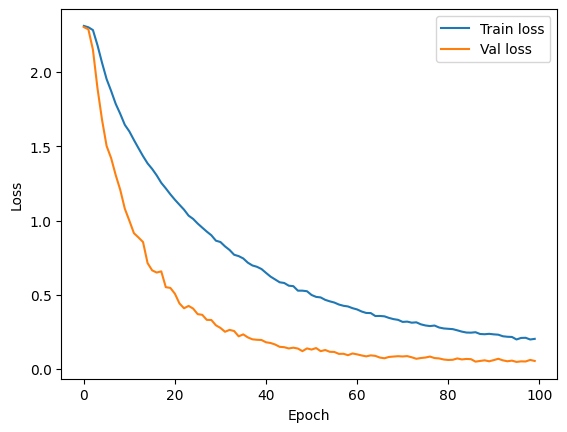

In [60]:
plt.plot(hist_cct['train_loss'], label='Train loss')
plt.plot(hist_cct['val_loss'], label='Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

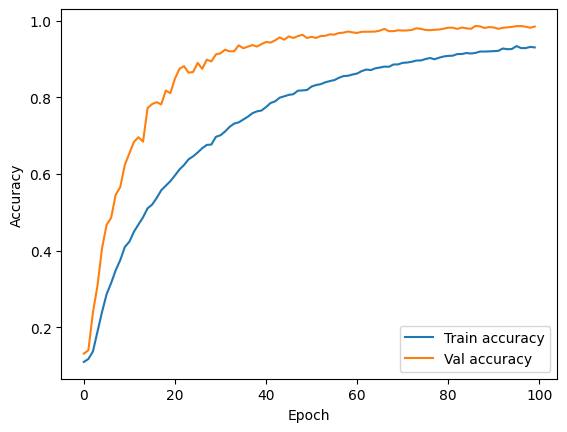

In [61]:
plt.plot(hist_cct['train_acc'], label='Train accuracy')
plt.plot(hist_cct['val_acc'], label='Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [62]:
cm = get_metrics(cct_model, val_dl, 10)

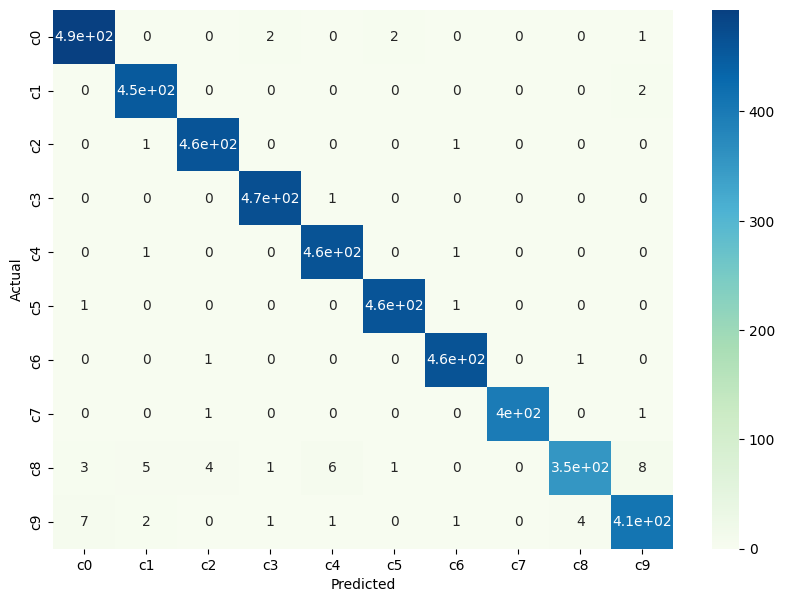

In [63]:
df_cm = pd.DataFrame(cm, index = [cl for cl in classes],
                     columns = [cl for cl in classes])
plt.figure(figsize = (10, 7))
sns.heatmap(df_cm, annot=True, cmap='GnBu')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [67]:
torch.save(cct_model.state_dict(), 'cct_model.pth')

## 6 - Models comparison

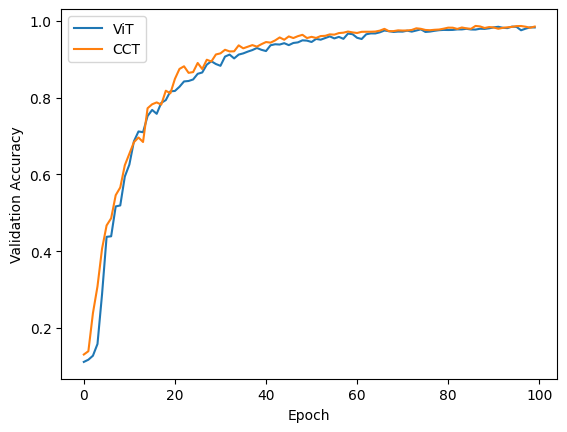

In [64]:
plt.plot(hist_vit['val_acc'], label='ViT')
plt.plot(hist_cct['val_acc'], label='CCT')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()

In [65]:
saliency_vit = compute_saliency_maps(X, y, vit_model)
saliency_cct = compute_saliency_maps(X, y, cct_model)

if USE_GPU:
    saliency_vit = saliency_vit.cpu().numpy()
    saliency_cct = saliency_cct.cpu().numpy()
else:
    saliency_vit = saliency_vit.numpy()
    saliency_cct = saliency_cct.numpy()

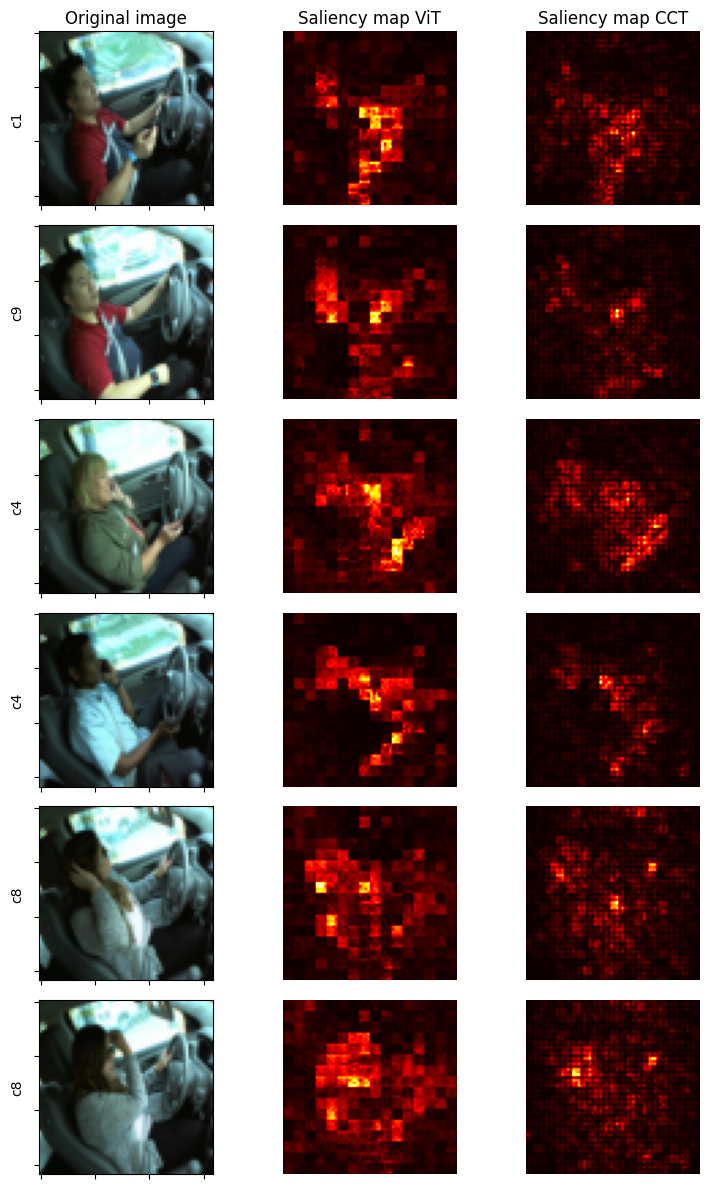

In [66]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
imgs = X * std[None, :, None, None] + mean[None, :, None, None]

num_imgs = 6
fig, ax = plt.subplots(num_imgs, 3, figsize=(8, num_imgs*2))

for i in range(num_imgs):
    image = imgs[i].numpy()
    image = np.transpose(image, (1, 2, 0))
    ax[i, 0].imshow((image * 255).astype(np.uint8))
    ax[i, 0].set_ylabel(classes[y[i]])
    ax[i, 0].set_yticklabels([])
    ax[i, 0].set_xticklabels([])

    ax[i, 1].imshow(saliency_vit[i], cmap=plt.cm.hot)
    ax[i, 1].axis('off')
    
    ax[i, 2].imshow(saliency_cct[i], cmap=plt.cm.hot)
    ax[i, 2].axis('off')

ax[0, 0].set_title('Original image')
ax[0, 1].set_title('Saliency map ViT')
ax[0, 2].set_title('Saliency map CCT')

fig.tight_layout()